In [1]:
import numpy as np 
import os
import pandas as pd
import itertools
import scipy.special as special 
import torch 
import torch.nn as nn 
from torch.autograd import Variable 
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import KFold
import json
import warnings
from torch import nn
from torch.optim import Adam,LBFGS
import pickle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
jsi_data = '/content/drive/MyDrive/Colab Notebooks/Deep Learning S22/24789 EE Project/JSI Preprocessing/Aligned & Interpolated/1Hz/'
slade_data = '/content/drive/MyDrive/Colab Notebooks/Deep Learning S22/24789 EE Project/Slade Preprocessing/Aligned & Interpolated/1 Hz/'

In [5]:
data_select = 'all'

In [6]:
if data_select == 'all':
  source_list = ['ANKLE','THIGH','HR']
if data_select == 'accelerometer':
  source_list = ['ANKLE','THIGH']
if data_select == 'Heart Rate':
  source_list = ['HR']
if data_select == 'all plus activity':
  source_list = ['ANKLE','THIGH','HR']
if data_select == 'imu plus activity':
  source_list = ['ANKLE','THIGH']
if data_select == 'heart rate plus activity':
  source_list = ['HR']



In [7]:
# device = 'cpu' #'cuda:0' if torch.cuda.is_available() else 'cpu'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
if device == torch.device('cpu'):
  num_workers = 0
else:
  torch.cuda.empty_cache()
  num_workers = 2


cuda


In [8]:
def activity_data_convert(activity_name,data_len):
  if activity_name == 'Walk':
    activity_num = 0
  if activity_name == 'Run':
    activity_num = 1
  if activity_name == 'Stairclimb':
    activity_num = 2
  if activity_name == 'Cycle':
    activity_num = 3

  output_list = activity_num*np.ones(data_len)
  output_list = np.expand_dims(output_list, axis=1)
  return output_list

In [9]:
#JSI Data
data_list = []
target_list =[]
activity_list =[]
for filename in os.listdir(jsi_data):
  if 'Person' in filename:
    temp = pd.read_csv(jsi_data+'/'+filename)
    target_cols = [col for col in temp.columns if 'COSMED' in col]
    target_list.append(temp[target_cols].values)
    data_cols = [col for col in temp.columns for j in source_list if j in col ]
    input_data = temp[data_cols].values
    temp_name = filename.split(sep='_')[1]
    activity_name = temp_name.replace(".csv","")
    if 'plus activity' in data_select:
        output_list = activity_data_convert(activity_name,len(input_data))
        input_data = np.append(input_data, output_list,1)
    data_list.append(input_data)
    
    activity_list.append(activity_name)
    #data_list.append(EE_Dataset(target_list,input_data,activity_name))
print(len(data_list))
print(len(activity_list))

24
24


In [10]:
print(np.shape(data_list))

(24,)


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [11]:
for filename in os.listdir(slade_data):
  if '.csv' in filename:
    temp = pd.read_csv(slade_data+'/'+filename)
    target_cols = [col for col in temp.columns if 'MET' in col and not 'MET HR' in col]
    target_list.append(temp[target_cols].values)
    data_cols = [col for col in temp.columns for j in source_list if j in col ]
    input_data = temp[data_cols].values
    
    
    #1- quiet standing
    #2- walking at 1.0 m/s
    #3- walking at 1.5 m/s
    #4- running at 2.5 m/s
    #5- running at 3.0 m/s
    #6- climbing stairs at 50 steps/min
    #7- climbing stairs at 70 steps/min
    #8- biking with resistance of 50 Watts
    #9- biking with resistance of 120 Watts 

    if 'C02' in filename or 'C03' in filename:
      activity_name = 'Walk'
    elif 'C04' in filename or 'C05' in filename:
      activity_name = 'Run'
    elif 'C06' in filename or 'C07' in filename:
      activity_name = 'Stairclimb'
    elif 'C08' in filename or 'C09' in filename:
      activity_name = 'Cycle'
    #print(activity_name)
    if 'plus activity' in data_select:
        output_list = activity_data_convert(activity_name,len(input_data))
        input_data = np.append(input_data, output_list,1)
#    output_list = activity_data_convert(activity_name,len(input_data))
#    input_data = np.append(input_data, output_list,1)
    activity_list.append(activity_name)


    data_list.append(input_data)
    #data_list.append(EE_Dataset(target_list,input_data,activity_name))
print(len(activity_list))
print(len(target_list))
print(np.shape(data_list))

180
180
(180,)


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [12]:
# change activity_list from strings to numbers 
activity_labels = [0 if x == 'Walk' else x for x in activity_list]
activity_labels = [1 if x == 'Run' else x for x in activity_labels]
activity_labels = [2 if x == 'Stairclimb' else x for x in activity_labels]
activity_labels = [3 if x == 'Cycle' else x for x in activity_labels]

target_list =activity_labels

In [13]:
from torch.nn.utils.rnn import pad_sequence
new_data_list = np.zeros_like(data_list)

for i in range(0,180):
  data_list[i] = torch.Tensor(data_list[i])

data_list = pad_sequence(data_list, batch_first = True, padding_value = 0)

print(np.shape(new_data_list))


(180,)


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [14]:
class CNNModel(nn.Module):
  def __init__(self, input_dim,dropout,output_dim=1,device = device):
    super(CNNModel, self).__init__()
    # build your model here
    # your input should be of dim (batch_size, seq_len, input_size)
    # your output should be of dim (batch_size, seq_len, input_size) as well
    
    self.input_dim = input_dim
    self.output_dim = output_dim
 
    self.cnn1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(8,1), stride=(6,1), padding=1) # 8x223 x 223 out
    self.relu1 = nn.ReLU()
    self.batch1 = nn.BatchNorm2d(8)
    self.maxpool1 = nn.MaxPool2d(kernel_size=(4,1), stride = 2) #8 x 110 x 110

    self.cnn2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(6,1), stride=(4,1), padding=1) # 16 x 54 x 54 out 
    self.relu2 = nn.ReLU()
    self.batch2 = nn.BatchNorm2d(16)
    self.maxpool2 = nn.MaxPool2d(kernel_size=(4,1), stride = 1) #16 x 51 x 51

    self.cnn3 = nn.Conv2d(in_channels=16, out_channels=4, kernel_size=(4,1), stride=(2,1), padding=0) # 8 x 61 x 61
    self.relu3 = nn.ReLU()
    self.batch3 = nn.BatchNorm2d(4)
    self.maxpool3 = nn.MaxPool2d(kernel_size=(4,1), stride = 1) #8 x 29 x 29 

    # Fully connected 1
    self.fc1 = nn.Linear(56, 4) #56 for all, 48 for imus
    self.softmax = nn.Softmax(dim = 1)
    self.dropout = nn.Dropout(dropout)

  def forward(self,x):
    # TODO: Perform forward pass in below section 
    # Example:
    out = self.cnn1(x)
    out = self.relu1(out)      
    out = self.batch1(out)
    out = self.maxpool1(out) 
    out = self.dropout(out)

    out = self.cnn2(out)
    out = self.relu2(out)      
    out = self.batch2(out)
    out = self.maxpool2(out) 
    out = self.dropout(out)

    out = self.cnn3(out)
    out = self.relu3(out)      
    out = self.batch3(out)
    out = self.maxpool3(out)
    out = self.dropout(out)

    out = out.view(out.size(0), -1)
    out = self.fc1(out)
    out = self.softmax(out)
    
    return out




In [16]:
for i in range(0,180):
  temp = data_list[i,:,:].numpy()
  new_data_list[i] = temp

In [17]:
test_idx = np.random.choice(np.shape(new_data_list)[0], np.shape(new_data_list)[0]//5, replace=False).tolist()
train_idx = list(set(range(np.shape(new_data_list)[0])) - set(test_idx))
train_data = [new_data_list[i] for i in train_idx]
test_data = [new_data_list[i] for i in test_idx]
train_target = [target_list[i] for i in train_idx]
test_target = [target_list[i] for i in test_idx]


In [18]:
from torch.utils.data import Dataset
class Energy_Expenditure(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y
    self.len = len(self.X)
  def __getitem__(self, index):

    return torch.Tensor(self.X[index]), self.y[index]
  def __len__(self):
    return self.len

In [19]:
train = Energy_Expenditure(train_data, train_target)
test = Energy_Expenditure(test_data, test_target)

In [20]:
from torch.nn.utils.rnn import pad_sequence
from pdb import set_trace as st

def pad_collate(batch):
  (xx, yy) = zip(*batch)
  x_lens = [len(x) for x in xx]
  y_lens = [1 for y in yy]

  xx_pad = pad_sequence(xx, batch_first=True, padding_value=0)
  yy_pad = yy

  return xx_pad, yy_pad, x_lens, y_lens

train_loader = DataLoader(dataset=train, batch_size=40, shuffle=True, num_workers=4, collate_fn=pad_collate)
test_loader = DataLoader(dataset=test, batch_size=40, shuffle=True, num_workers=4, collate_fn=pad_collate)

num_epochs = 0
lr = 0.001

if data_select == 'all':
  input_size = 7
if data_select == 'accelerometer':
  input_size = 6
if data_select == 'Heart Rate':
  input_size = 1

dropout = 0.05 #.2

model = CNNModel(input_dim=input_size, dropout = dropout)
# device = torch.device("cuda")
model.to(device)
# model.to(torch.double) 

    # define your LSTM loss function here
criterion =  nn.CrossEntropyLoss()

    # define optimizer for lstm model
    #optim = LBFGS(model.parameters(), lr=0.08)
optim = Adam(model.parameters(), lr=lr,betas=(0.9, 0.999))
print(model)

epoch_list = []
loss_list = []
for epoch in range(num_epochs):

      for n_batch, [in_batch, label, in_len, label_len] in enumerate(train_loader):
            # print(np.shape(in_batch))
            in_batch = in_batch.unsqueeze(1).to(device)
            label_ = torch.zeros(np.shape(label), dtype = torch.long)
            for idx, val in enumerate(label):
              label_[idx] = label[idx]
            # print(label_)
            label = label_.to(device)

           # train LSTM
            output = model(in_batch)
            # print("Output: ", output)
            # print("Label: ", label)
            loss = criterion(output, label)
            [pred, ind] = output.max(dim = 1)
            # print(ind)
            # print(label)
            acc = (ind == label).float().mean().item() * 100
            print(acc)
            print(f'Loss: {loss.item():.2f}') #| Prediction: {output.max(1)[1]}    |   Accuracy: {acc:.1f} %   |   
            optim.zero_grad()
            loss.backward()
            optim.step()
      epoch_list.append(epoch)
      loss_list.append(loss.item())

            # # # print loss while training

            # if (n_batch + 1) % 5 == 0:
            #      print("Epoch: [{}/{}], Batch: [{}/{}], Loss: {}".format(
            #      epoch, num_epochs, n_batch + 1, len(train_loader), loss.item()))
            #      epoch_list.append(epoch)
            #      loss_list.append(loss.item())
            #      print(np.shape(loss_list))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


CNNModel(
  (cnn1): Conv2d(1, 8, kernel_size=(8, 1), stride=(6, 1), padding=(1, 1))
  (relu1): ReLU()
  (batch1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=(4, 1), stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(8, 16, kernel_size=(6, 1), stride=(4, 1), padding=(1, 1))
  (relu2): ReLU()
  (batch2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=(4, 1), stride=1, padding=0, dilation=1, ceil_mode=False)
  (cnn3): Conv2d(16, 4, kernel_size=(4, 1), stride=(2, 1))
  (relu3): ReLU()
  (batch3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool3): MaxPool2d(kernel_size=(4, 1), stride=1, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=56, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
  (dropout): Dropout(p=0.05, inplace=False)
)


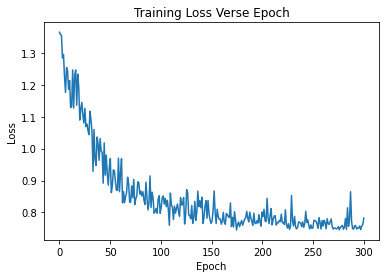

In [ ]:
from matplotlib import pyplot as plt
plt.figure()
plt.plot(np.linspace(0,len(loss_list),len(loss_list)),loss_list)
plt.title('Training Loss Verse Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
test_err =  0
model.eval()
with torch.no_grad():
    for n_batch, [in_batch, label, in_len, label_len] in enumerate(test_loader):
        in_batch = in_batch.unsqueeze(1).to(device)
        label_ = torch.zeros(np.shape(label), dtype = torch.long)
        for idx, val in enumerate(label):
          label_[idx] = label[idx]
        label = label_.to(device)
        pred = model(in_batch)

        test_err += criterion(pred, label).item()
        [_, ind] = pred.max(dim = 1)
        print(ind)
        print(label)
        acc = (ind == label).float().mean().item() * 100
        print(acc)

    print("Test error:", test_err)



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


tensor([3, 0, 2, 0, 0, 3, 3, 3, 2, 1, 2, 2, 2, 2, 0, 3, 3, 3, 0, 1, 0, 2, 3, 3,
        2, 2, 2, 2, 0, 3, 1, 3, 0, 1, 3, 2])
tensor([3, 0, 2, 0, 0, 3, 3, 3, 2, 1, 2, 2, 2, 3, 3, 3, 0, 2, 0, 1, 0, 2, 3, 3,
        2, 2, 3, 2, 1, 3, 1, 3, 0, 1, 3, 2])
83.33333134651184
Test error: 0.8900236487388611


In [ ]:
# saving model 
path = '/content/drive/MyDrive/Colab Notebooks/Deep Learning S22/24789 EE Project/CNNModel_all_state.pth' 

# with open(Pkl_Filename, 'wb') as file:  
#     pickle.dump(CNNModel, file)

# torch.save(CNNModel, path)
# torch.save(model.state_dict(), path)

In [ ]:
# try to evaluate on entire dataset 
all_load = Energy_Expenditure(new_data_list, target_list)
all_loader = DataLoader(dataset=all_load, batch_size = 40, shuffle=False, num_workers=4, collate_fn=pad_collate)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
#predict labels for all
all_test_err =  0
num_correct = 0
all_label = []
model.eval()
with torch.no_grad():
    for n_batch, [in_batch, label, in_len, label_len] in enumerate(all_loader):
        in_batch = in_batch.unsqueeze(1).to(device)
        label_ = torch.zeros(np.shape(label), dtype = torch.long)
        for idx, val in enumerate(label):
          label_[idx] = label[idx]
        label = label_.to(device)
        pred = model(in_batch)
        all_test_err += criterion(pred, label).item()
        [_, ind] = pred.max(dim = 1)
        print(ind)
        all_label.append(ind)
        print(label)
        temp = (ind == label).float().sum().item()
        num_correct += temp
        print(temp)
        # acc = (ind == label).float().mean().item() * 100
        # print(acc)
    acc = (num_correct) * (5/9)
    print(acc)

    print("Test error:", all_test_err)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


tensor([3, 1, 3, 0, 1, 3, 0, 1, 3, 0, 1, 3, 0, 1, 3, 1, 0, 3, 0, 1, 3, 0, 1, 3,
        0, 0, 1, 0, 2, 2, 3, 3, 0, 0, 1, 1, 2, 2, 3, 3])
tensor([0, 1, 3, 0, 1, 3, 0, 1, 3, 0, 1, 3, 0, 1, 3, 1, 0, 3, 0, 1, 3, 0, 1, 3,
        0, 0, 1, 1, 2, 2, 3, 3, 0, 0, 1, 1, 2, 2, 3, 3])
38.0
tensor([0, 0, 1, 1, 2, 2, 3, 3, 0, 0, 1, 1, 2, 2, 3, 3, 0, 0, 1, 1, 2, 2, 3, 3,
        0, 0, 1, 1, 2, 2, 3, 3, 0, 0, 1, 1, 2, 2, 3, 3])
tensor([0, 0, 1, 1, 2, 2, 3, 3, 0, 0, 1, 1, 2, 2, 3, 3, 0, 0, 1, 1, 2, 2, 3, 3,
        0, 0, 1, 1, 2, 2, 3, 3, 0, 0, 1, 1, 2, 2, 3, 3])
40.0
tensor([0, 0, 2, 3, 3, 0, 0, 1, 1, 2, 2, 3, 3, 0, 0, 1, 1, 2, 2, 3, 3, 0, 0, 2,
        3, 3, 0, 0, 2, 2, 3, 3, 0, 0, 1, 1, 2, 2, 3, 2])
tensor([0, 0, 2, 3, 3, 0, 0, 1, 1, 2, 2, 3, 3, 0, 0, 1, 1, 2, 2, 3, 3, 0, 0, 2,
        3, 3, 0, 0, 2, 2, 3, 3, 0, 0, 1, 1, 2, 2, 3, 3])
39.0
tensor([0, 0, 3, 3, 0, 0, 2, 3, 3, 0, 0, 1, 2, 3, 3, 0, 0, 1, 2, 2, 3, 3, 0, 0,
        2, 3, 3, 0, 0, 2, 3, 0, 0, 0, 2, 2, 3, 3, 0, 0])
tensor([0, 0, 3, 3, 0, 0, 

In [ ]:
all_label = np.hstack(all_label)
print(all_label)
print(target_list)
print(all_label == target_list)

[3 1 3 0 1 3 0 1 3 0 1 3 0 1 3 1 0 3 0 1 3 0 1 3 0 0 1 0 2 2 3 3 0 0 1 1 2
 2 3 3 0 0 1 1 2 2 3 3 0 0 1 1 2 2 3 3 0 0 1 1 2 2 3 3 0 0 1 1 2 2 3 3 0 0
 1 1 2 2 3 3 0 0 2 3 3 0 0 1 1 2 2 3 3 0 0 1 1 2 2 3 3 0 0 2 3 3 0 0 2 2 3
 3 0 0 1 1 2 2 3 2 0 0 3 3 0 0 2 3 3 0 0 1 2 3 3 0 0 1 2 2 3 3 0 0 2 3 3 0
 0 2 3 0 0 0 2 2 3 3 0 0 3 3 0 0 2 3 3 0 0 2 3 3 0 0 1 1 2 3 3 2]
[0, 1, 3, 0, 1, 3, 0, 1, 3, 0, 1, 3, 0, 1, 3, 1, 0, 3, 0, 1, 3, 0, 1, 3, 0, 0, 1, 1, 2, 2, 3, 3, 0, 0, 1, 1, 2, 2, 3, 3, 0, 0, 1, 1, 2, 2, 3, 3, 0, 0, 1, 1, 2, 2, 3, 3, 0, 0, 1, 1, 2, 2, 3, 3, 0, 0, 1, 1, 2, 2, 3, 3, 0, 0, 1, 1, 2, 2, 3, 3, 0, 0, 2, 3, 3, 0, 0, 1, 1, 2, 2, 3, 3, 0, 0, 1, 1, 2, 2, 3, 3, 0, 0, 2, 3, 3, 0, 0, 2, 2, 3, 3, 0, 0, 1, 1, 2, 2, 3, 3, 0, 0, 3, 3, 0, 0, 2, 3, 3, 0, 0, 1, 2, 3, 3, 0, 0, 1, 2, 2, 3, 3, 0, 0, 2, 3, 3, 0, 0, 2, 3, 3, 0, 0, 2, 2, 3, 3, 0, 0, 3, 3, 0, 0, 2, 3, 3, 0, 0, 2, 3, 3, 0, 0, 1, 1, 2, 2, 3, 3]
[False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  

In [ ]:
save_path = '/content/drive/MyDrive/Colab Notebooks/Deep Learning S22/24789 EE Project/labels_hr.npy' 

np.save(save_path, all_label)